In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyproj import Proj, transform
import utm


Here I am taking out the bias's from the imu_df Readings by taking the first 10 readings since first 10 readings represent the vehicle at rest so any values apart from zero represent noise so taking the mean of the first 10 readings and substracting it from the entire IMU data removing Bias

In [3]:
imu_df = pd.read_csv('imu_data.csv')
gps_df = pd.read_csv('gps_data.csv')
valid_gps = gps_df['latitude'].notna() & gps_df['longitude'].notna()
gps_clean_temp = gps_df[valid_gps].reset_index(drop=True)
first_gps_time = gps_clean_temp['timestamp'].iloc[0]

imu_df = imu_df[imu_df['timestamp'] >= first_gps_time].reset_index(drop=True)
imu_df['ax'] = imu_df['ax'] * 9.81
imu_df['ay'] = imu_df['ay'] * 9.81
imu_df['az'] = imu_df['az'] * 9.81
stationary_sample = 200
stationary_imu = imu_df.iloc[:stationary_sample]


#Bias_calculated 
bias_ax = np.mean(stationary_imu['ax'])
bias_ay= np.mean(stationary_imu['ay'])
bias_az = np.mean(stationary_imu['az'])
bias_wx= np.mean(stationary_imu['wx'])
bias_wy = np.mean(stationary_imu['wy'])
bias_wz= np.mean(stationary_imu['wz'])

#Bias Removeed
imu_df['ax'] = imu_df['ax'] - bias_ax
imu_df['ay'] = imu_df['ay'] - bias_ay
imu_df['az'] = imu_df['az'] - bias_az
imu_df['wx'] = imu_df['wx'] - bias_wx
imu_df['wy'] = imu_df['wy'] - bias_wy
imu_df['wz'] = imu_df['wz'] - bias_wz




# Calculate variance from bias-corrected data
std_ax = np.std(stationary_imu['ax'])
std_ay = np.std(stationary_imu['ay'])
std_az = np.std(stationary_imu['az'])

std_wx = np.std(stationary_imu['wx'])
std_wy = np.std(stationary_imu['wy'])
std_wz = np.std(stationary_imu['wz'])

var_ax = std_ax**2
var_ay = std_ay**2
var_az = std_az**2
var_wx = std_wx**2
var_wy = std_wy**2
var_wz = std_wz**2

print(f"σ_ax = {std_ax:.6f}, var_ax = {var_ax:.9f}, ax_b = {bias_ax: 9f}")
print(f"σ_ay = {std_ay:.6f}, var_ay = {var_ay:.9f}, ay_b = {bias_ay: 9f}")
print(f"σ_wz = {std_wz:.6f}, var_wz = {var_wz:.9f}, wz_b = {bias_wz: 9f}")


# qx = imu_df['ox']
# qy = imu_df['oy']
# qz = imu_df['oz']
# qw = imu_df['ow']

# roll_imu = np.arctan2(2 * (qw * qx + qy * qz), 1 - 2 * (qx**2 + qy**2))
# pitch_imu = np.arcsin(np.clip(-2 * (qx * qz - qw * qy), -1.0, 1.0))
# yaw_imu = np.arctan2(2 * (qw * qz + qx * qy), 1 - 2 * (qy**2 + qz**2))

# imu_df['roll'] = roll_imu
# imu_df['pitch'] = pitch_imu
# imu_df['yaw'] = yaw_imu

# print(imu_df[['timestamp', 'roll', 'pitch', 'yaw']].head())

# # --- Bias estimation window (first few seconds) ---
# t_bias = 1.0  # seconds to average for bias estimation
# t0 = imu_df['timestamp'].iloc[0]
# init_window = imu_df[imu_df['timestamp'] <= t0 + t_bias]

# acc_bias_x = init_window['ax'].mean()
# acc_bias_y = init_window['ay'].mean()
# gyro_bias_z = init_window['wz'].mean()
# print(f"\nEstimated biases - acc_x: {acc_bias_x:.6f}, acc_y: {acc_bias_y:.6f}, gyro_z: {gyro_bias_z:.6f}")

# # --- Bias removal ---
# imu_df['ax_unbiased'] = imu_df['ax'] - acc_bias_x
# imu_df['ay_unbiased'] = imu_df['ay'] - acc_bias_y
# imu_df['gz_unbiased'] = imu_df['wz'] - gyro_bias_z

# ax_unbiased = imu_df['ax_unbiased']
# ay_unbiased = imu_df['ay_unbiased']
# gz_unbiased = imu_df['gz_unbiased']

σ_ax = 1.859343, var_ax = 3.457157884, ax_b = -6.727603
σ_ay = 3.378573, var_ay = 11.414754299, ay_b =  2.500846
σ_wz = 0.006454, var_wz = 0.000041648, wz_b = -0.037106


Defining the State vector

State_x = [x,y,theta,vx,vy,omega]

Assuming constant velocity model

Motion Model

Let k+1 be next state and k is previous state

x_k+1 = x_k + vxdt 

y-k+1 = y_k + vydt 

theta_k+1 = theta_k + omega*dt 

vx_k+1 = vx_k + a_x * dt 

vy_k+1 = vy_k + a_y * dt 

omega = wz

Rotating ax to world frame using theta which we get by motion model with the help of gyro reading in z direction

ax_world = axcos(theta) - aysin(theta) ay_world = axsin(theta) + aycos(theta)

In [4]:
#State Vector [x,y,theta,vx,vy,omega] 
# ax_b = -6.727603
# acc_x: -0.010168
#state vec at t = 0
state_x = np.array([0,0,0,0,0,0])
dt = imu_df['timestamp']
dt = np.diff(dt)
dt = np.mean(dt)
print(dt)


#Motion Model (Constant velocity model)

def Motion_model(states, ax,ay,wz,dt):
    
    x,y,theta,vx,vy,omega = states
    ax_world = ax * np.cos(theta) - ay * np.sin(theta)
    ay_world = ax * np.sin(theta) + ay * np.cos(theta)
    x_new = x + vx * dt
    y_new = y + vy * dt
    theta_new = theta + omega * dt
    vx_new = vx + ax_world * dt
    vy_new = vy + ay_world * dt
    omega_new = wz 

    predicted =  np.array([x_new, y_new, theta_new, vx_new, vy_new, omega_new])
    return predicted

first_imu = imu_df.iloc[1]  
print(first_imu)

print(f"  IMU reading: ax={first_imu['ax']:.6f}, ay={first_imu['ay']:.6f}, wz={first_imu['wz']:.6f}")

new_state = Motion_model(state_x, first_imu['ax'], first_imu['ay'], first_imu['wz'], dt)
print(f"  Initial state:   {state_x}")
print(f"  Predicted state: {new_state}")



0.005001139628284449
timestamp    1.697740e+09
ax           1.818805e+00
ay          -1.137652e+00
az          -8.562513e-01
wx          -7.668504e-03
wy           3.421312e-03
wz          -2.714806e-03
ox          -1.136306e-02
oy          -1.947820e-02
oz          -5.759157e-03
ow           9.997292e-01
Name: 1, dtype: float64
  IMU reading: ax=1.818805, ay=-1.137652, wz=-0.002715
  Initial state:   [0 0 0 0 0 0]
  Predicted state: [ 0.          0.          0.          0.0090961  -0.00568956 -0.00271481]


Process Covariance

P = F@P_previous@F^T + Q

here the F matrix is the state transition matrix which capture how the previous states add uncertainty to new state

P_previous is the covariance of the previous predicted state

Q is the covariance matrix that captures the uncertainty added by the IMU noisy readings in the prediction of the new state for example here: Q[0,0] = 0.25·dt⁴·var_ax: Acceleration noise in the x-direction integrates twice giving the dt⁴/4 factor for position uncertainty Q[0,3] = 0.5·dt³·var_ax: Cross-covariance between x and vx. Since the same acceleration noise affects both position and velocity simultaneously, their uncertainties become correlated Q[3,0] = Same value as Q[0,3] because covariance matrices are symmetric

The same logic is applied in determining other rows of the Q

In [20]:
#Calculation Of Process Covariance 
#State transition matrix for [x, y, θ, vx, vy, ω] here only x,y,theta are getting affected by the F matrix due to velocity terms so this just captures the uncertainty in pose 

def get_F_matrix(dt,theta, ax, ay):
    F = np.array([
        [1, 0, 0, dt, 0,  0],
        [0, 1, 0, 0,  dt, 0],
        [0, 0, 1, 0,  0,  dt],
        [0, 0, (-ax*np.sin(theta) - ay*np.cos(theta))*dt,  1,  0,  0],
        [0, 0, (ax*np.cos(theta) - ay*np.sin(theta))*dt, 0,  1,  0],
        [0, 0, 0, 0,  0,  1]
    ])
    return F

#Process noise covariance matrix this matrix Q captures the uncertainty caused by IMU readings(noise profile of IMU) in pose and velocity 
# def get_Q_matrix(var_ax, var_ay, var_wz, dt):
    
#     Q = np.array([
#         [0.25*dt**4*var_ax,  0,                  0,              0.5*dt**3*var_ax,  0,                 0           ],
#         [0,                  0.25*dt**4*var_ay,  0,              0,                 0.5*dt**3*var_ay,  0           ],
#         [0,                  0,                  dt**2*var_wz,   0,                 0,                 dt*var_wz   ],
#         [0.5*dt**3*var_ax,   0,                  0,              dt**2*var_ax,      0,                 0           ],
#         [0,                  0.5*dt**3*var_ay,   0,              0,                 dt**2*var_ay,      0           ],
#         [0,                  0,                  dt*var_wz,      0,                 0,                 var_wz      ]
#     ])
#     return Q

P = np.eye(6) * np.array([10, 10, 100, 100, 100, 100])

# Store results
state_x = np.array([0,0,0,0,0,0])
states = [state_x.copy()]
covariances = [P.copy()]

# F = get_F_matrix(dt,state_x[2], imu_df['ax'], imu_df['ay'])
# Q = get_Q_matrix(var_ax, var_ay, var_wz, dt)
Q = np.diag([0.05, 0.05, 10,0.05,0.05, 0.5]) 
for i in range(1, len(imu_df)):
    imu = imu_df.iloc[i]
    # Predict state
    state_n = Motion_model(state_x, imu['ax'], imu['ay'], imu['wz'], dt)
    F = get_F_matrix(dt,state_x[2], imu['ax'], imu['ay'])
    # how old predicted states covariance propogates along with the IMU noise uncertainty added which is captured by Q 
    P = F @ P @ F.T + Q
    state_x = state_n 
    states.append(state_n)
    covariances.append(P.copy())

states = np.array(states)
covariances = np.array(covariances)
print(states[3970])




[4.56574001e+02 1.20061300e+03 1.60524046e+00 4.82478499e+01
 1.30719652e+02 1.12938502e-02]


Measurement Model

converting the latitude and longitude to x,y

defining the H matrix that extracts the pose x,y

MEASUREMENT Noise

computed the R matrix that captures the uncertainty in the GPS readings by taking the covariance of the first 5 readings since first 5 readings are at rest


In [18]:
print(states[3970])

[4.56574001e+02 1.20061300e+03 1.60524046e+00 4.82478499e+01
 1.30719652e+02 1.12938502e-02]


In [6]:
gps_df = pd.read_csv('gps_data.csv')

valid_gps = gps_df['latitude'].notna() & gps_df['longitude'].notna()
gps = gps_df[valid_gps].reset_index(drop=True)
lat_origin = gps['latitude'].iloc[0]
lon_origin = gps['longitude'].iloc[0]

def latlon_to_meters(lat, lon, lat_origin, lon_origin):
    y = (lat - lat_origin) * 111000 
    x = (lon - lon_origin) * 111000 * np.cos(np.radians(lat_origin))
    return x, y

gps['x'] = 0.0
gps['y'] = 0.0


for i in range(len(gps)):
    x, y = latlon_to_meters(
        gps['latitude'].iloc[i],
        gps['longitude'].iloc[i],
        lat_origin,
        lon_origin
    )
    gps.loc[i, 'x'] = x
    gps.loc[i, 'y'] = y

# print(gps_clean)



# std_gpsx = np.std(gps['x'].iloc[:70])
# std_gpsy = np.std(gps['y'].iloc[:70])

# var_gpsx = std_gpsx**2
# var_gpsy = std_gpsy**2

# R = np.array([[var_gpsx, 0],
#               [0, var_gpsy]])

# print(R)
# gps = gps_df.dropna(subset=['latitude', 'longitude']).reset_index(drop=True)
# utm_coords = [utm.from_latlon(lat, lon) for lat, lon in zip(gps['latitude'], gps['longitude'])]
# gps['e'] = [u[0] for u in utm_coords]
# gps['n'] = [u[1] for u in utm_coords]
# e0, n0 = gps['e'].iloc[0], gps['n'].iloc[0]
# gps['x'] = gps['e'] - e0
# gps['y'] = gps['n'] - n0

In [ ]:
#gps_df = pd.read_csv('gps_data.csv')

# 
#  print(covariances[3])
# gps_df = pd.read_csv('gps_data.csv')


# gps_clean = gps_df[valid_gps].reset_index(drop=True)


# utm_proj = Proj(proj='utm', zone=19, ellps='WGS84')
# wgs84 = Proj(proj='latlong', datum='WGS84')

# def latlon_to_utm(lat, lon):
#     x, y = transform(wgs84, utm_proj, lon, lat) 
#     return x, y

# gps_clean['x'] = 0.0
# gps_clean['y'] = 0.0


# for i in range(len(gps_clean)):
#     x, y = latlon_to_utm(
#         gps_clean['latitude'].iloc[i],
#         gps_clean['longitude'].iloc[i]
#     )
#     gps_clean.loc[i, 'x'] = x
#     gps_clean.loc[i, 'y'] = y

# first_x = gps_clean['x'].iloc[0]
# first_y = gps_clean['y'].iloc[0]
# print(first_x,first_y)
# gps_clean['x'] = gps_clean['x'] - first_x
# gps_clean['y'] = gps_clean['y'] - first_y




# std_gpsx = np.std(gps_clean['x'].iloc[:80])
# std_gpsy = np.std(gps_clean['y'].iloc[:80])

# var_gpsx = std_gpsx**2
# var_gpsy = std_gpsy**2

# R = np.array([[var_gpsx, 0],
#               [0, var_gpsy]])

# print(R)

#My plots vere not good so i thought maybe R matrix is wrong i just tried to convert the gps coordinates to UTM using pyporj but it didnt made a difference + it takes too much time to run 
#this code snippet so i comented it 

Algorithm steps

computing the innovation step by taking the difference y^ between the predicted pose (x,y) and the GPS(x,y)

the computed difference is actually not the true difference it has uncertainty to model this uncertainty we use S which captures this uncertainty of this difference WHERE S = H@P_previous@H^T + R

H is the matrix that's used to extract just the pose x,y and the R matrix is the noise uncertainty due to the GPS readings

then defining the kalman Gain K = P@H^T@Inv(S)

updating the predicted state as x_new = x_predicted + K*y^

update Process covariance P = (I-K@H)@P where I is a 6x6 identity matrix

initial state is takes as [gps_first_x,gps_fiest_y,0,0,0,0]

In [ ]:
H = np.array([[1, 0, 0, 0, 0, 0],
              [0, 1, 0, 0, 0, 0]])
R = np.diag([5.0, 5.0]) 
print(R)
Q = np.diag([0.05, 0.05, 10,0.05,0.05, 0.5]) 
first_gps_x = gps['x'].iloc[0]
first_gps_y = gps['y'].iloc[0]
state_x = np.array([first_gps_x, first_gps_y, 0.0, 0.0, 0.0, 0.0])
P = np.eye(6) * np.array([1, 1, 1000, 1000, 1000, 1000])

states_kf = [state_x.copy()]
covariances_kf = [P.copy()]


gps_idx = 0 
gps_dict = {}


for i in range(len(gps)):
    t = gps['timestamp'].iloc[i]
    gps_dict[t] = (gps['x'].iloc[i], gps['y'].iloc[i])
update_count = 0


states_predicted_by_motion_model = [state_x.copy()]

#for S to be high P and R has to be high 
#P will be high cuz of the 
gps_update_indices = []
for i in range(1, len(imu_df)):
    imu = imu_df.iloc[i]
    
   
    state_n = Motion_model(state_x, imu['ax'], imu['ay'], imu['wz'], dt)
    states_predicted_by_motion_model.append(state_n)
    F = get_F_matrix(dt,state_x[2], imu['ax'], imu['ay'])
    P = F @ P @ F.T + Q
    
    
    
    imu_time = imu['timestamp']
    while gps_idx < len(gps) and gps['timestamp'].iloc[gps_idx] < imu_time - 0.05:
        gps_idx += 1 
    
    if gps_idx < len(gps) and abs(gps['timestamp'].iloc[gps_idx] - imu_time) < 0.05:
        update_count += 1   
        gps_update_indices.append(i)
        gps_x = gps['x'].iloc[gps_idx]
        gps_y = gps['y'].iloc[gps_idx]
        z = np.array([gps_x, gps_y])
        y = z - H @ state_n
        
        S = H @ P @ H.T + R   
        # print('s',S)
        K = P @ H.T @ np.linalg.inv(S)
        # print('P @ H.T', P @ H.T)
        # print('k',K)
        state_for_printing = state_n
        state_n = state_n + K @ y
        I = np.eye(6)
        P = (I - K @ H) @ P
        gps_idx += 1 
        if update_count == 1:
            print(f"First GPS update:")
            print(f"  GPS measurement: [{gps_x:.2f}, {gps_y:.2f}]")
            print(f"  Predicted state: [{state_n[0]:.2f}, {state_n[1]:.2f}]")
            print(f"  Innovation: [{y[0]:.2f}, {y[1]:.2f}]")
            print(f"  K[0,0]={K[0,0]:.3f}")
    
        if update_count % 100 == 0:
            print(f'  Current IMU index i: {i}')
            print(f'  GPS index: {gps_idx}')
            print(f"\n{update_count}th GPS update:")
            print(f"  GPS: [{gps_x:.2f}, {gps_y:.2f}]")
            print(f"  State after update: [{state_n[0]:.2f}, {state_n[1]:.2f}]")
            print(f"  States predicted by motion model: [{state_for_printing[0]:.2f}], [{state_for_printing[1]:.2f}]")
            print(f"  K[0,0]={K[0,0]:.3f}")
    
    states_kf.append(state_n)
    covariances_kf.append(P.copy())
    state_x = state_n 


states_kf = np.array(states_kf)
covariances_kf = np.array(covariances_kf)

print(f"Kalman filtercomplete!")
print(f"States shape: {states_kf.shape}")

print(f"Number of GPS updates: {update_count}")


[[5. 0.]
 [0. 5.]]
First GPS update:
  GPS measurement: [0.00, 0.00]
  Predicted state: [0.00, 0.00]
  Innovation: [0.00, 0.00]
  K[0,0]=0.177
  Current IMU index i: 1970
  GPS index: 100

100th GPS update:
  GPS: [25.68, -3.92]
  State after update: [25.70, -3.91]
  States predicted by motion model: [25.75], [-3.88]
  K[0,0]=0.681
  Current IMU index i: 3970
  GPS index: 200

200th GPS update:
  GPS: [70.95, -45.40]
  State after update: [71.03, -45.07]
  States predicted by motion model: [71.25], [-44.58]
  K[0,0]=0.691
  Current IMU index i: 5990
  GPS index: 301

300th GPS update:
  GPS: [131.27, -98.59]
  State after update: [131.19, -98.63]
  States predicted by motion model: [130.94], [-98.78]
  K[0,0]=0.722
  Current IMU index i: 7990
  GPS index: 401

400th GPS update:
  GPS: [154.42, -118.86]
  State after update: [154.38, -118.82]
  States predicted by motion model: [154.34], [-118.76]
  K[0,0]=0.643
  Current IMU index i: 9990
  GPS index: 501

500th GPS update:
  GPS: [167

predicted state vs kf state 
predicted_states -274.79159077685637
states_kf -271.31632268402404
(21843, 6)
gps vs kf state 
gps_xy 1740.4188530948902
states_kf 1740.3192215612657
[ True  True  True ...  True  True  True]


C:\Users\shalh\AppData\Local\Temp\ipykernel_20704\4245800129.py:37: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


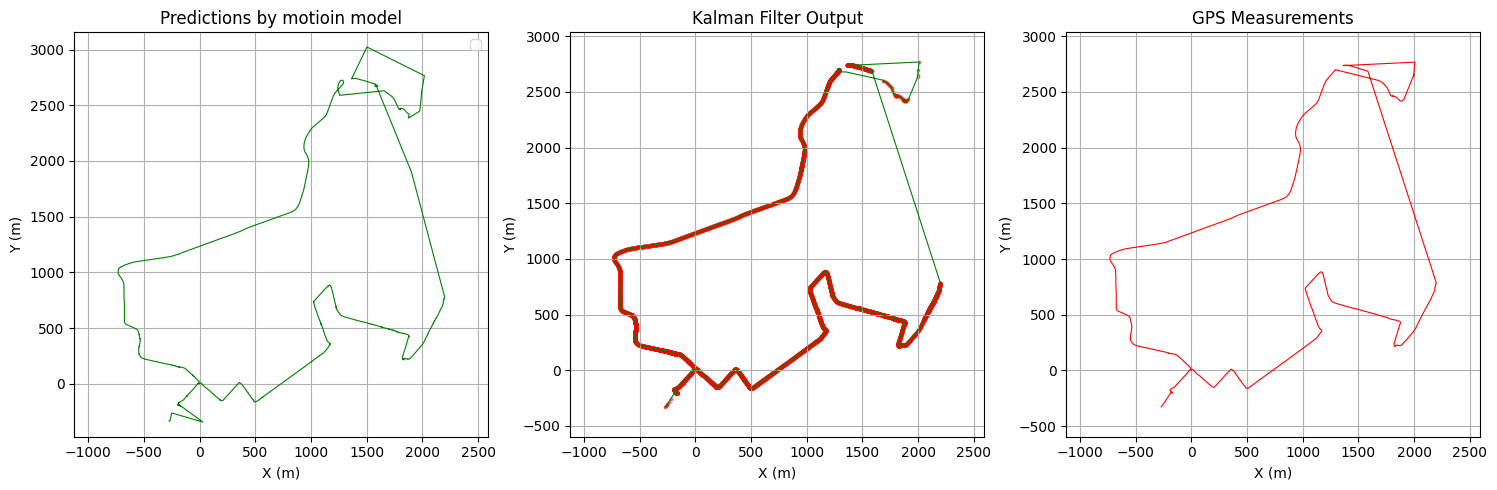

In [ ]:
states_p = np.array(states_predicted_by_motion_model)
gps_update_indices = np.array(gps_update_indices)


states_kf_updates = states_kf[gps_update_indices]
states_c = states_p[gps_update_indices]


print('predicted state vs kf state ')
print("predicted_states", states_c[-1,0])
print("states_kf", states_kf_updates[-1,0])
print(states_c.shape)

print('gps vs kf state ')
print("gps_xy", gps['x'][7916])
print("states_kf", states_kf[158311,0])


mask = (np.abs(states_c[:, 0]) < 10000) & (np.abs(states_c[:, 1]) < 10000)
states_c_filtered = states_c[mask]





plt.figure(figsize=(15, 5))

# Plot 1: Prediction trajectory
plt.subplot(1, 3, 1)
plt.plot(states_c_filtered[:, 0], states_c_filtered[:, 1],  'g-', linewidth=0.8)
plt.xlabel('X (m)')
plt.ylabel('Y (m)')
plt.title('Predictions by motioin model')
plt.grid(True)
plt.axis('equal')
plt.legend()



# Plot 2: Kalman filter trajectory
plt.subplot(1, 3, 2)
plt.plot(states_kf_updates[:, 0], states_kf_updates[:, 1], 'g-', linewidth=0.8)
plt.scatter(gps['x'], gps['y'], c='r', s=3, alpha=0.5, label='GPS')
plt.xlabel('X (m)')
plt.ylabel('Y (m)')
plt.title('Kalman Filter Output')
plt.grid(True)
plt.axis('equal')



# Plot 3: GPS trajectory
plt.subplot(1, 3, 3)
plt.plot(gps['x'], gps['y'], 'r-', linewidth=0.8)
plt.xlabel('X (m)')
plt.ylabel('Y (m)')
plt.title('GPS Measurements')
plt.grid(True)
plt.axis('equal')

plt.tight_layout()
plt.show()